# Forwards Amortise Optimisation

Note: This is running on the development version of dLux, so it will not be able to be replicated until the changes are merged

In [1]:
# Packages
import jax
import zodiax as zdx
import equinox as eqx
import dLux as dl
import optax

# Modules
from jax import numpy as np, random as jr, tree_util as jtu
from dLux import layers as dll, utils as dlu
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 96
%matplotlib inline

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_cbar(fig, ax, im, location='right', size='5%', pad=0.1, orientation='vertical'):
    """Adds a colorbar to a figure
    
    Params:
        fig: matplotlib figure
        ax: matplotlib axes
        location: str, location of the colorbar
        size: float, size of the colorbar
        pad: float, padding of the colorbar
        orientation: str, orientation of the colorbar
    
    Returns:
        fig: matplotlib figure
        ax: matplotlib axes"""
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(location, size=size, pad=pad)
    fig.colorbar(im, cax=cax, orientation=orientation)
    return fig

def plot_grid_2d(rows, cols, fsx=5, fsy=4, nested=False):
    """Returns a figure and axes arranged in a 2d grid
    
    Params:
        rows: int, number of rows
        cols: int, number of columns
        fsx: float, individual figure size in x
        fsy: float, individual figure size in y
        nested: bool, whether to return a nested list of axes or a flat list
    
    Returns:
        fig: matplotlib figure
        axes: list of matplotlib axes arranged in a 2d grid"""
    fig = plt.figure(figsize=(fsx*cols, fsy*rows))
    axes = []
    for j in range(rows):
        axes_tmp = []
        for i in range(cols):
            ax = plt.subplot(rows, cols, i + j*cols + 1)

            if nested:
                axes_tmp.append(ax)
            else:
                axes.append(ax)
        if nested:
            axes.append(axes_tmp)
    return fig, axes

def compare_layers(initial, final):
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.title("Initial Weights")
    plt.imshow(initial.weight)
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("Final Weights")
    plt.imshow(final.weight)
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.title("Weight Difference")
    plt.imshow(initial.weight - final.weight)
    plt.colorbar()

    plt.subplot(1, 4, 4)
    xs = np.arange(len(initial.bias))
    plt.scatter(xs, initial.bias, label='Initial')
    plt.scatter(xs, final.bias, label='Final')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Make Optics

In [3]:
# Source parameters
wavelengths = 1e-6 * np.linspace(1., 1.2, 5)
source = dl.PointSource(wavelengths, flux=1e4)

# Wavefront parameters
wf_npix = 256
aper_diam = 2.4

# Generate an aperture manually
coords = dlu.pixel_coords(5*wf_npix, 2.4)
spider_angles = 45 + np.linspace(0, 360, 4, endpoint=False)
outer = dlu.circle(coords, aper_diam/2)
inner = dlu.circle(coords, .3, True)
spiders = dlu.spider(coords, .05, spider_angles)
aperture = dlu.combine([outer, inner, spiders], 5)

# Generate coordinates
coords = dlu.pixel_coords(wf_npix, 2.4)
zernikes = np.arange(2, 4)
basis = np.array([1e-9 * dlu.zernike(i, coords, aper_diam) for i in zernikes])
coeffs = 4e1 * jr.normal(jr.PRNGKey(0), (len(zernikes),))

# PSF parameters
psf_wf_npix = 64
sampling = 3 # ie 1.5x Nyquist
fringe_size = dlu.fringe_size(wavelengths, aper_diam).min()
psf_pix_scale = 1.22 * dlu.rad2arcsec(fringe_size) / sampling

# Construct optics
psf_oversample = 3
layers = [('aperture', dll.BasisOptic(
    aperture, basis, coeffs, normalise=True
))]
optics = dl.AngularOptics(
    wf_npix, aper_diam, layers, psf_wf_npix, psf_pix_scale / psf_oversample
    )

# Bind the source to the optics for a simple function signature
model_psf = lambda optics: optics.model(source)

## Examine

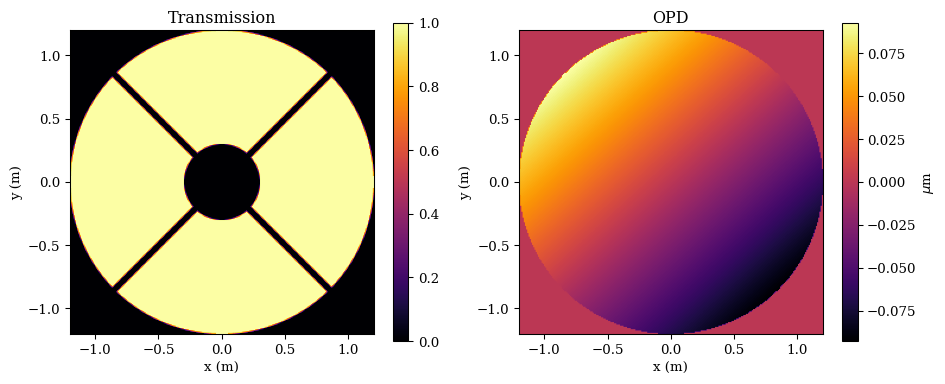

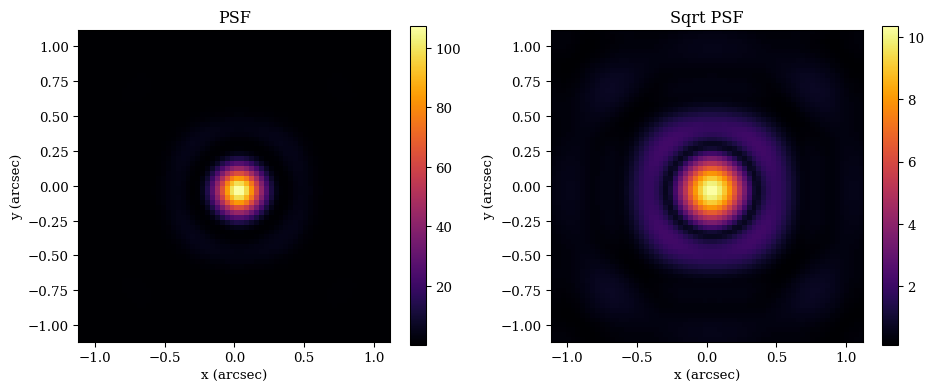

In [4]:
# Aperture plots
r = aper_diam/2
extent = (-r, r, -r, r)

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.set(xlabel='x (m)', ylabel='y (m)', title='Transmission')
plt.imshow(optics.transmission, extent=extent)
plt.colorbar()

ax2 = plt.subplot(1, 2, 2)
ax2.set(xlabel='x (m)', ylabel='y (m)', title='OPD')
plt.imshow(1e6 * optics.eval_basis(), extent=extent)
plt.colorbar(label='$\mu$m')
plt.tight_layout()
plt.show()

# PSF plots
psf = model_psf(optics)
r = psf_pix_scale * psf_wf_npix / 2
extent = (-r, r, -r, r)

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.set(xlabel='x (arcsec)', ylabel='y (arcsec)', title='PSF')
plt.imshow(psf, extent=extent)
plt.colorbar()

ax2 = plt.subplot(1, 2, 2)
ax2.set(xlabel='x (arcsec)', ylabel='y (arcsec)', title='Sqrt PSF')
plt.imshow(psf**0.5, extent=extent)
plt.colorbar()
plt.tight_layout()
plt.show()

## Optimiser Class

In [5]:
hard_tanh = jax.nn.hard_tanh
sigmoid = jax.nn.sigmoid
relu = jax.nn.relu
identity = lambda x: x

class OptNet(eqx.Module):
    params: list
    model: object
    optimiser: object
    learn_rate: float

    def __init__(
        self, 
        model, 
        params, 
        learn_rate, 
        key=0, 
        depth=0,
        width=None,
        rand=True, 
        activation=relu,
        final_activation=identity,
        use_bias=True,
        use_final_bias=True,
        ):
        """Constructs an MLP as an optimiser."""
        self.learn_rate = np.asarray(learn_rate, float)
        self.model = model
        self.params = params

        if width is None:
            width = len(self.format_input(model))
        in_shape = len(model.get(params))

        # Initialise the optimiser      
        optimiser = eqx.nn.MLP(
            in_size = in_shape, 
            out_size = width, 
            width_size = in_shape, 
            depth = depth, 
            activation = activation, 
            final_activation = final_activation, 
            use_bias = use_bias,
            use_final_bias = use_final_bias,
            key = jr.PRNGKey(key),
            )

        # Initialise values to zero
        if not rand:
            new_layers = [
                eqx.tree_at(
                    lambda tree: (tree.weight, tree.bias), 
                    layer, 
                    (layer.weight / layer.weight, 0 * layer.bias)
                ) 
                for layer in optimiser.layers
            ]
            optimiser = eqx.tree_at(lambda tree: tree.layers, optimiser, new_layers)
        self.optimiser = optimiser

    def __getattr__(self, name):
        if hasattr(self.optimiser, name):
            return getattr(self.optimiser, name)
        raise AttributeError(f"OptNet has no attribute {name}")

    def chi2(self, model, data):
        return np.square(model_psf(model) - data).mean()
    
    def poisson(psf, model, data):
        return jax.scipy.stats.poisson.logpmf(data, model_psf(model)).mean()
    
    def model_value(self, values):
        return model_psf(self.model.set(self.params, values))
    
    def model_values(self, values):
        return jax.vmap(self.model_value)(values)

    def eval_grads(self, values, data):
        loss_fn = lambda optics: self.chi2(optics, data)
        grads = eqx.filter_grad(loss_fn)(self.model.set(self.params, values))
        return grads.multiply(self.params, self.learn_rate)

    def format_input(self, tree):
        """Formats the loss and grads pytree into a flat vector"""
        vals_list = jtu.tree_flatten(tree.get(self.params))[0]
        return np.concatenate(jtu.tree_map(lambda x: x.flatten(), vals_list))

    def predict_step(self, values, data):
        """Return the predicted values"""
        grads = self.eval_grads(values, data)
        flat_grads = self.format_input(grads)
        return values - self.optimiser(flat_grads)
    
    def naive_step(self, values, data):
        """Return the naive step"""
        grads = self.eval_grads(values, data)
        flat_grads = self.format_input(grads)
        return values - flat_grads

    def simple_loss(self, values, data):
        initial_loss = self.chi2(self.model.set(self.params, values), data)
        predicted_values = self.predict_step(values, data)
        predicted_model = self.model.set(self.params, predicted_values)
        final_loss = self.chi2(predicted_model, data)
        return final_loss - initial_loss

## Optimiser Loss & Training Functions

In [6]:
def loss_fn(diff_model, static_model, values, data, truth):
    model = eqx.combine(diff_model, static_model)
    return model.simple_loss(values, data)

def batched_loss(diff_model, static_model, values, data, truth):
    batched_fn = eqx.filter_vmap(loss_fn, in_axes=(None, None, 0, None, None))
    return batched_fn(diff_model, static_model, values, data, truth).mean()

def train_single(model, samples, truth, lr=1., kth=50):
    """Trains the network on a set of random initialisations"""
    # Generate the data
    data = model.model_value(truth)

    # Make a filter to only train on the optimiser parameters
    false_tree = jtu.tree_map(lambda _: False, model)
    true_tree = jtu.tree_map(lambda _: True, model.optimiser)
    fpsec = eqx.tree_at(lambda tree: tree.optimiser, false_tree, true_tree)
    fpsec = eqx.tree_at(lambda tree: tree.learn_rate, fpsec, True)

    # Step function
    @eqx.filter_jit
    def make_step(model, opt_state, *args):
        """Hig-level jitter function"""
        diff_model, static_model = eqx.partition(model, fpsec)

        # Calculate loss and grads
        loss_grads = lambda *args: eqx.filter_value_and_grad(batched_loss)(*args)
        loss, grads = loss_grads(diff_model, static_model, *args)

        # Update model and return
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    # Gradient Processing and compiling
    optim = optax.adam(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    intial_loss, _, _ = make_step(model, opt_state, samples[0], data, truth)

    # Training loop
    losses = []
    with tqdm(range(len(samples)), desc='Loss') as t:
        for i in t:
            loss, model, opt_state = make_step(model, opt_state, samples[i], data, truth)
            if i % kth == 0:
                print(f'Epoch: {i}, Loss {loss.mean():.5}')
            losses.append(loss.mean())            
            t.set_description(f'Loss {loss.mean():.5}') # update the progress bar
    print(f'Final loss: {loss.mean():.5}')
    return model, np.array(losses)

def normal(n, size, shape, mu=0, sigma=1, key=0):
    return mu + (sigma * jr.normal(jr.PRNGKey(key), (n, size) + shape))

# Set up samples and train!

This takes ~10 minutes on my Laptop

In [7]:
# Sampling parameters - Can train 10 million samples in ~2 hours!
key, sigma = 0, 1e2
epochs, batch_size = 1000, 100
samples = normal(epochs, batch_size, zernikes.shape, sigma=sigma, key=key)

# Create model & Optimise
truth = np.zeros(zernikes.shape)
model = OptNet(optics, 'coefficients', 1e1, depth=2)
model_out, losses = train_single(model, samples, truth, lr=1e-1, kth=100)

Loss:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0, Loss -0.0089812
Epoch: 100, Loss -21.222
Epoch: 200, Loss -30.551
Epoch: 300, Loss -39.018
Epoch: 400, Loss -42.2
Epoch: 500, Loss -47.028
Epoch: 600, Loss -43.839
Epoch: 700, Loss -43.266
Epoch: 800, Loss -40.766
Epoch: 900, Loss -50.791
Final loss: -50.147


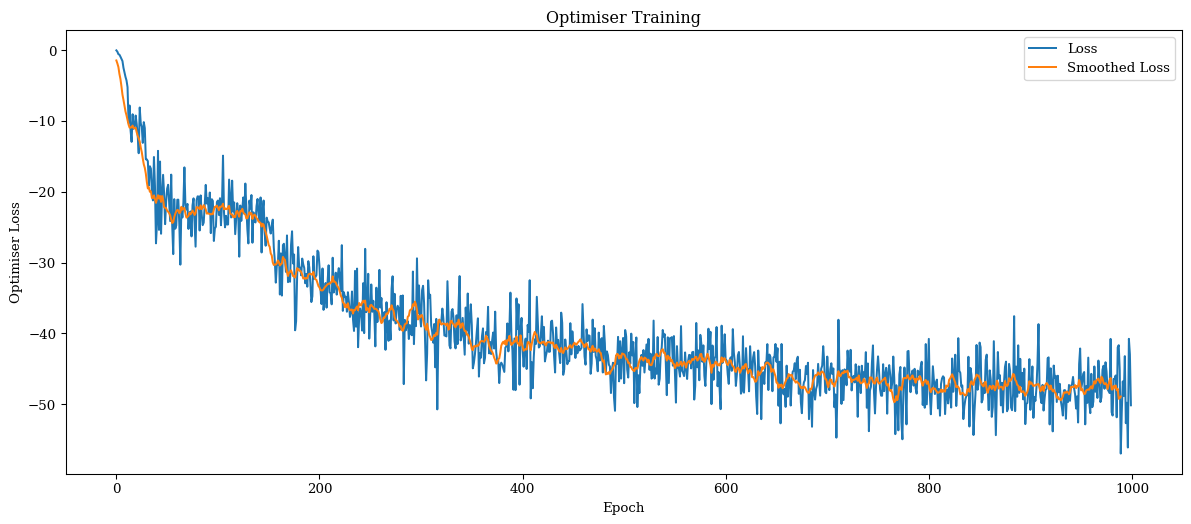

In [8]:
n = 10
def take_mean(arr, n):
    return np.array([arr[i:i+n].mean() for i in range(len(arr) - n)])
smooth_losses = take_mean(losses, n)

plt.figure(figsize=(15, 6))
plt.title("Optimiser Training")
plt.plot(losses, label='Loss')
plt.plot(smooth_losses, label='Smoothed Loss')
plt.xlabel('Epoch')
plt.ylabel('Optimiser Loss')
plt.legend()
plt.show()

# Examine the improvement from a single step

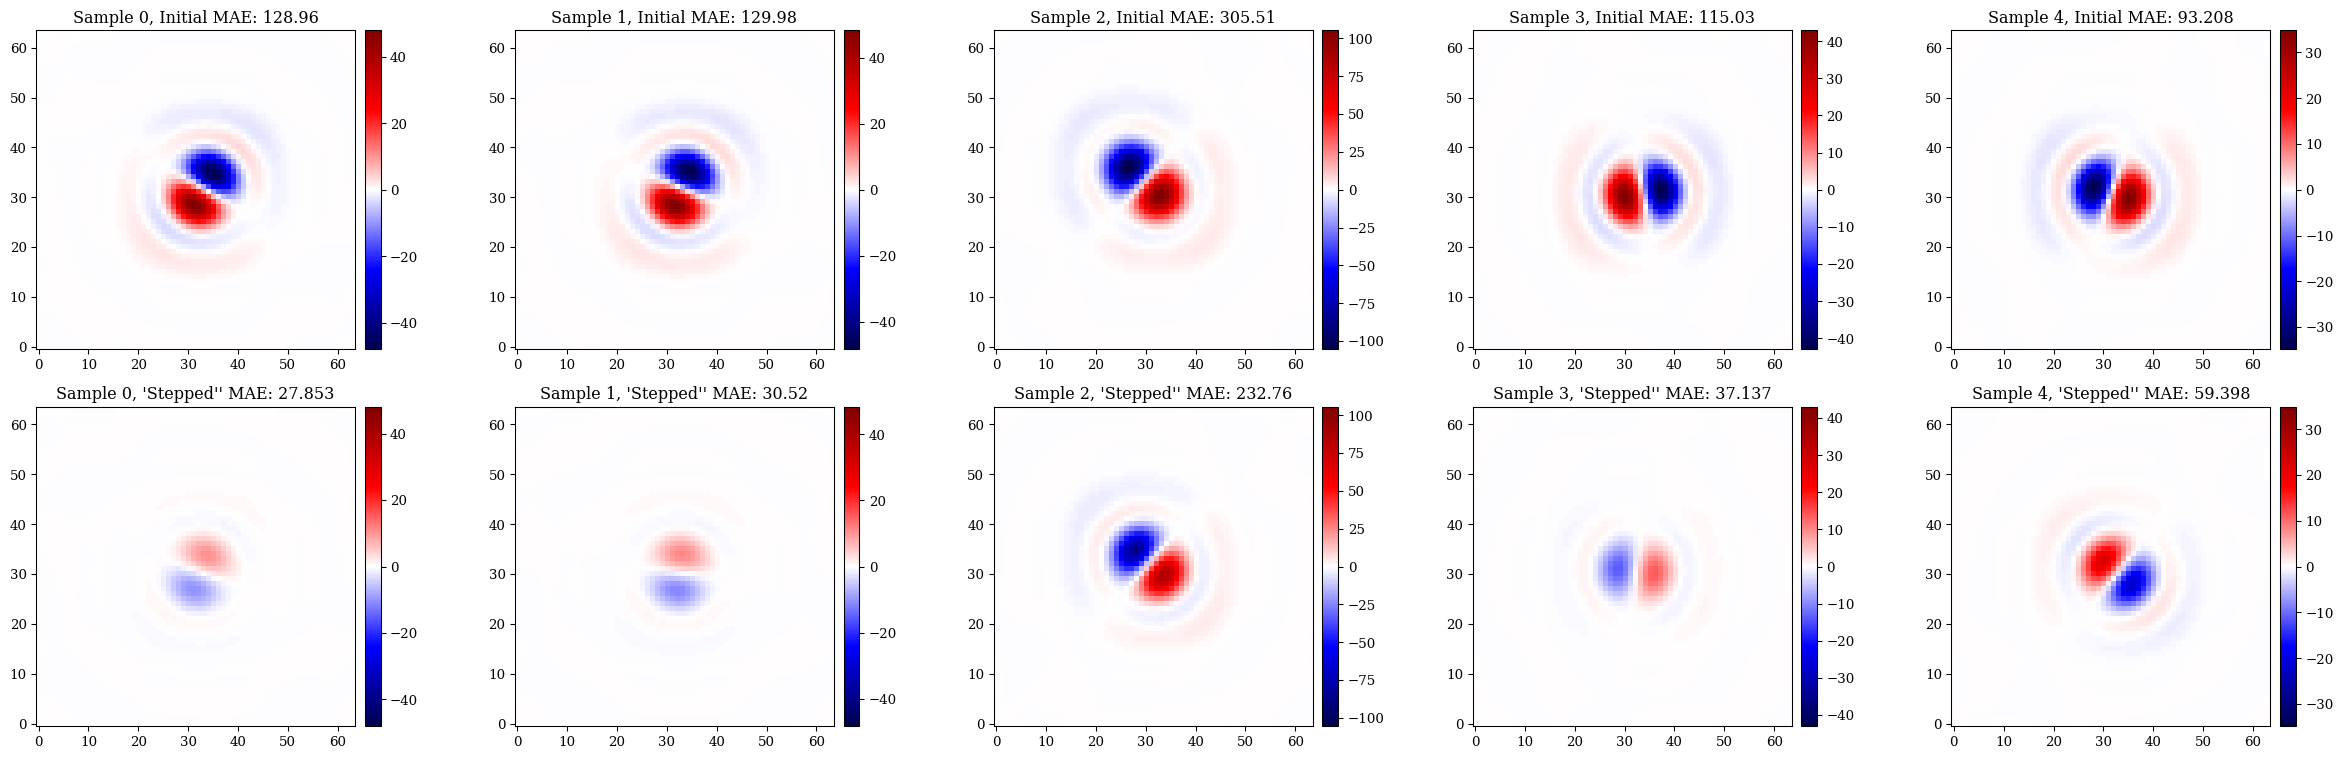

In [9]:
# Generate PSF
psf = model_psf(model.model)

# Get Initial Residuals
rows, cols = 1, 5
init_residuals = psf[None, ...] - model.model_values(samples[0, :rows*cols])
new_values = jax.vmap(model_out.predict_step, (0, None))(samples[0, :rows*cols], psf)
final_residuals = psf[None, ...] - model.model_values(new_values)

# Get normalisation values so we have same colour scale for each sample
vmin = init_residuals.min((-1, -2))
vmax = init_residuals.max((-1, -2))
v = np.abs(np.array([vmin, vmax])).max(0)

# Get a sample of the training samples
fig, axes = plot_grid_2d(2*rows, cols)

# Plot initial values
for i in range(len(axes)//2):
    axes[i].set(xlabel='', ylabel='', title=f"Sample {i}, Initial MAE: {1e2 * np.mean(np.abs(init_residuals[i])):.5}")
    im = axes[i].imshow(init_residuals[i], vmin=-v[i], vmax=v[i], cmap='seismic')
    fig = add_cbar(fig, axes[i], im)

# Plot final values
for i in range(len(axes)//2):
    j = i + rows*cols
    axes[j].set(xlabel='', ylabel='', title=f"Sample {i}, 'Stepped'' MAE: {1e2 * np.mean(np.abs(final_residuals[i])):.5}")
    im = axes[j].imshow(final_residuals[i], vmin=-v[i], vmax=v[i], cmap='seismic')
    fig = add_cbar(fig, axes[j], im)
fig.tight_layout()

# Compare trained optimiser to SGD

In [10]:
# Make some fake data
psf = model_psf(model.model)

# Initial Conditions
key, sigma = 0, 1e1
n_samples = 9
vals = np.squeeze(normal(n_samples, 1, zernikes.shape, sigma=sigma, key=key))

def update(model, values):
    return model.model.set(model.params, values)

n_train = 50
pred_losses, naive_losses = [], []
for j in tqdm(range(n_samples)):
    data = jr.poisson(jr.PRNGKey(j), psf)

    
    initial_loss = model.chi2(update(model_out, vals[j]), data)
    pred, naive = vals[j], vals[j]
    preds, naives = [pred], [naive]
    naive_losses_, pred_losses_ = [initial_loss], [initial_loss]
    for i in tqdm(range(n_train), leave=False):

        pred = model_out.predict_step(pred, data)
        naive = model_out.naive_step(naive, data)

        pred_loss = model.chi2(update(model_out, pred), data)
        naive_loss = model.chi2(update(model_out, naive), data)


        pred_losses_.append(pred_loss)
        naive_losses_.append(naive_loss)
    
    pred_losses.append(pred_losses_)
    naive_losses.append(naive_losses_)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

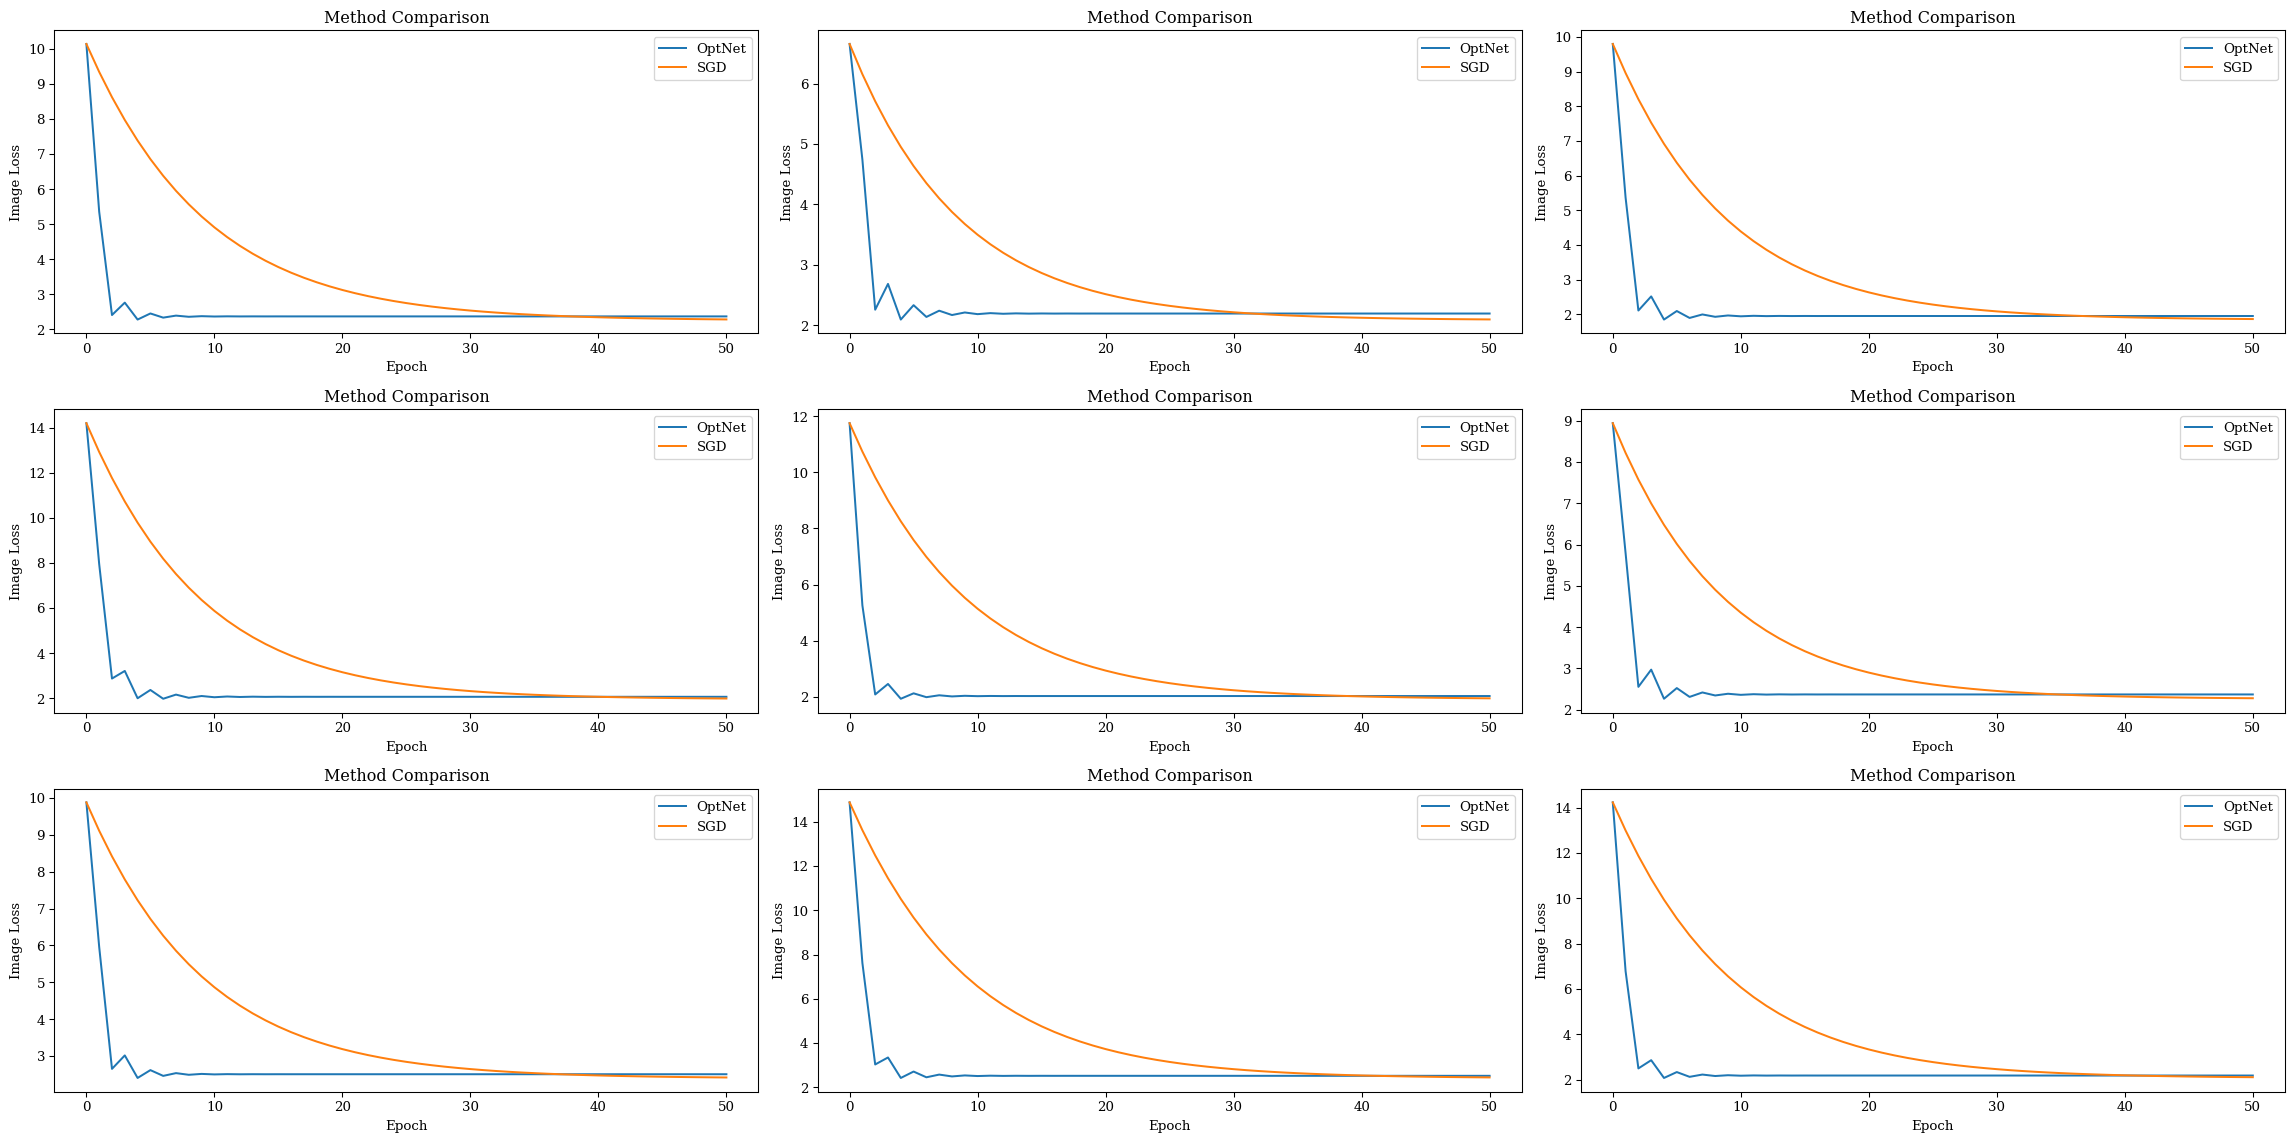

In [12]:
fig, axes = plot_grid_2d(3, 3, fsx=8)
for i in range(len(axes)):
    axes[i].set(xlabel='Epoch', ylabel='Image Loss', title=f"Method Comparison")
    axes[i].plot(pred_losses[i], label='OptNet')
    axes[i].plot(naive_losses[i], label='SGD')
    axes[i].legend()
fig.tight_layout()

initial_psf = model_psf(update(model_out, vals[0]))
final_psf = model_psf(update(model_out, vals[-1]))

# Examine optimiser values

6.4653106


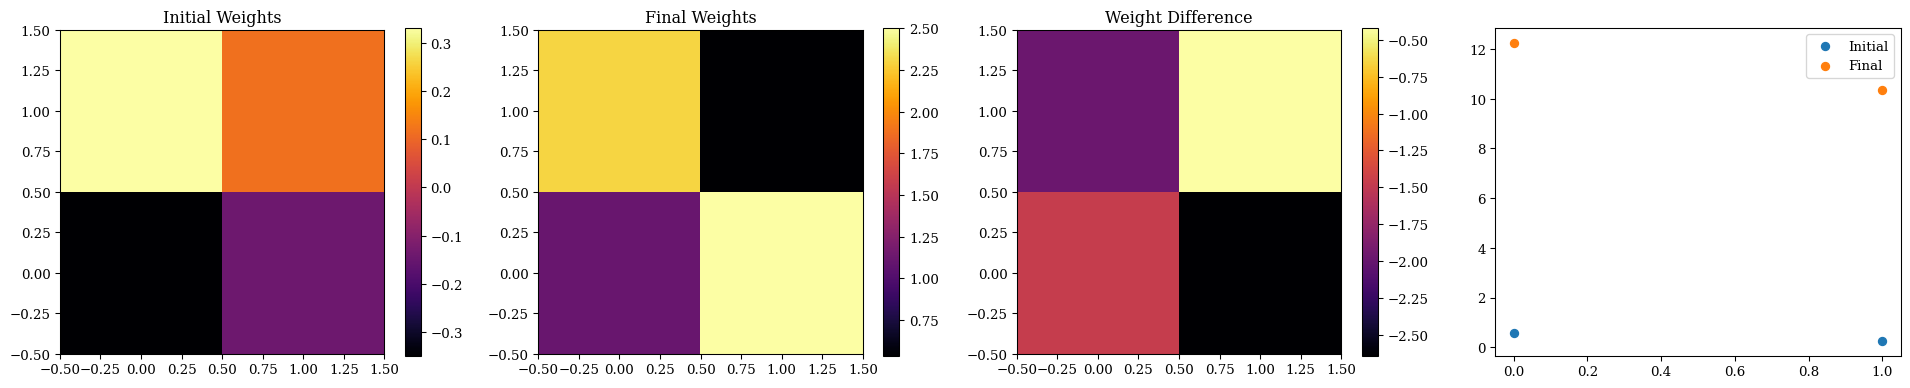

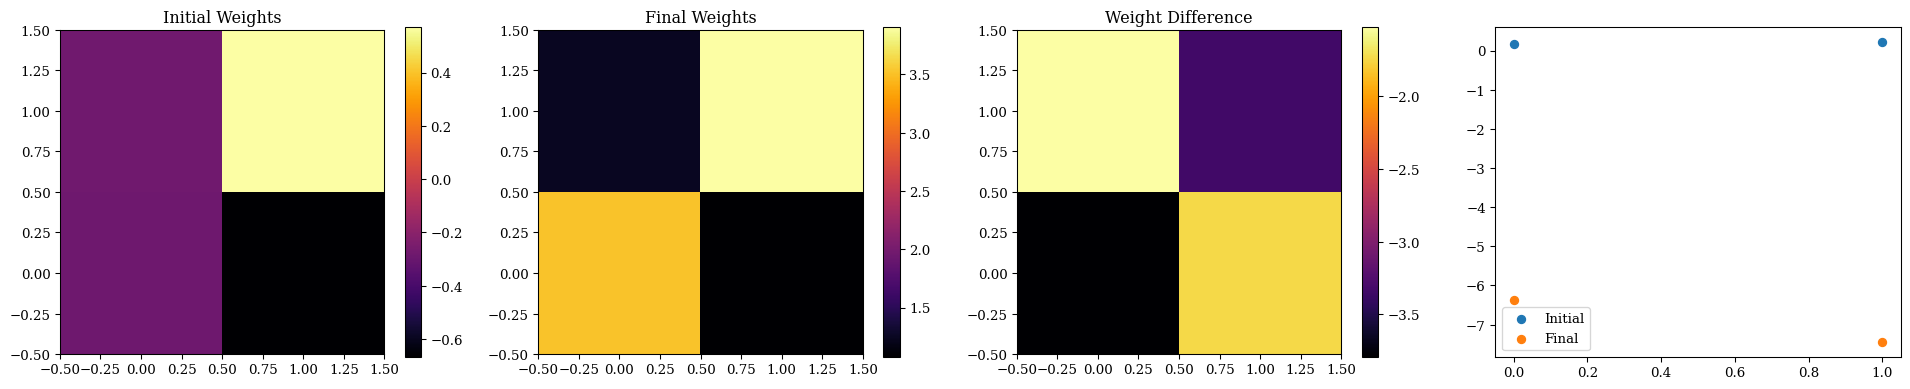

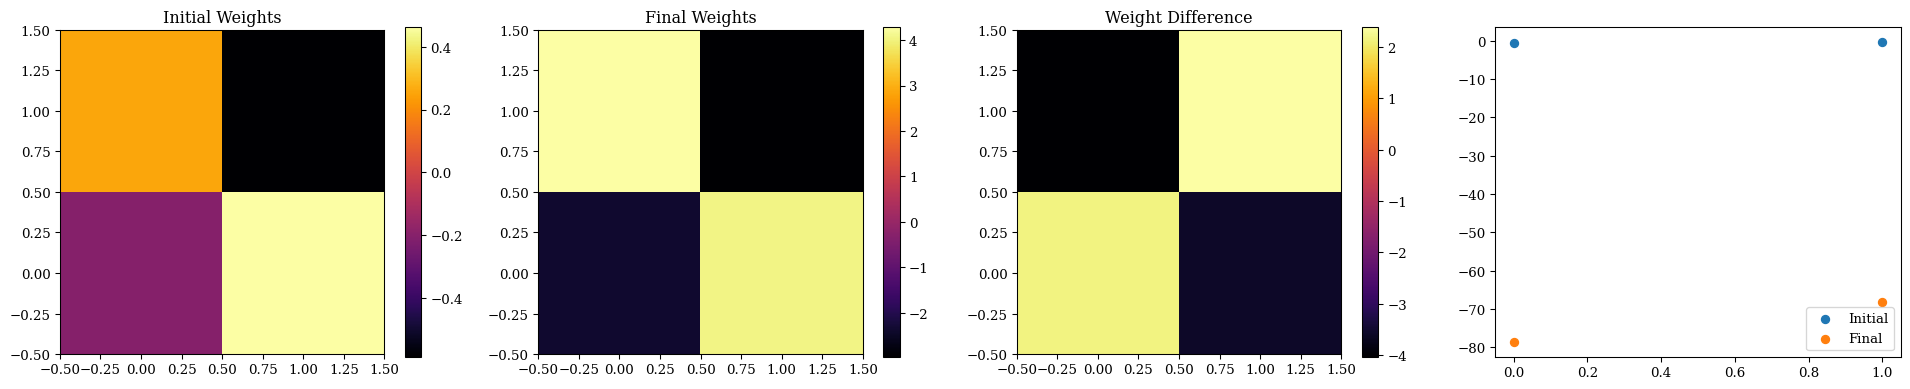

In [13]:
init_layers = model.optimiser.layers
final_layers = model_out.optimiser.layers

print(model_out.learn_rate)
for l1, l2 in zip(init_layers, final_layers): 
    compare_layers(l1, l2)